# Imports

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
import warnings
import logging
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import sklearn.preprocessing as prep

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
!unzip -q /gdrive/MyDrive/ANNDL/Homework2/training_dataset_homework2.zip

# Data processing

(2429,)
{0: 22.852941176470587, 1: 6.317073170731708, 2: 2.8777777777777778, 3: 2.0393700787401574, 4: 12.53225806451613, 5: 5.078431372549019, 6: 2.4824281150159746, 7: 11.426470588235293, 8: 6.475, 9: 1.0, 10: 10.090909090909092, 11: 15.235294117647058}
[ 34. 123. 270. 381.  62. 153. 313.  68. 120. 777.  77.  51.]


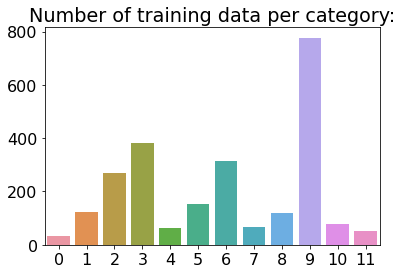

In [5]:
# Data load

x_data = np.load('x_train.npy')
y_data = np.load('y_train.npy')

print(y_data.shape)

# Plot the classes

classes = np.zeros(12)
for x in y_data:
  classes[x] +=1

sns.barplot(x=np.arange(12), y=classes).set_title("Number of training data per category:")
weight = max(classes)/classes
class_weight = {}
for i in range(12):
  class_weight[i] = weight[i]
print(class_weight)
print(classes)

In [7]:
# Preprocess the data
X_data = x_data


scaler = RobustScaler()
for i in range(len(X_data)):
  tmp = np.reshape(X_data[i],(X_data.shape[1]*X_data.shape[2],1))
  scaler = scaler.fit(tmp)
  tmp = scaler.transform(tmp)
  X_data[i] = np.reshape(tmp, (36,6))

X_data = np.reshape(X_data,(X_data.shape[0],X_data.shape[1],X_data.shape[2],1))


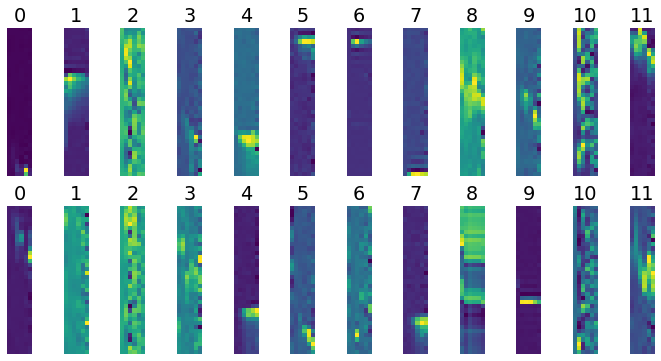

In [8]:
# Inspect the data
printX_data = np.reshape(X_data,(X_data.shape[0:3]))
num_row = 2
num_col = 12
fig, axes = plt.subplots(num_row, num_col, figsize=(1*num_col,3*num_row))

counter = 0
for c in range(12):
  start_index = np.where(y_data == c)[0][0]
  
  for i in range(num_row):
    ax = axes[counter%num_row,counter//num_row]
    ax.imshow(printX_data[i + start_index])
    ax.set_title(y_data[i + start_index])
    ax.axis('off')
    counter = counter + 1

plt.show()

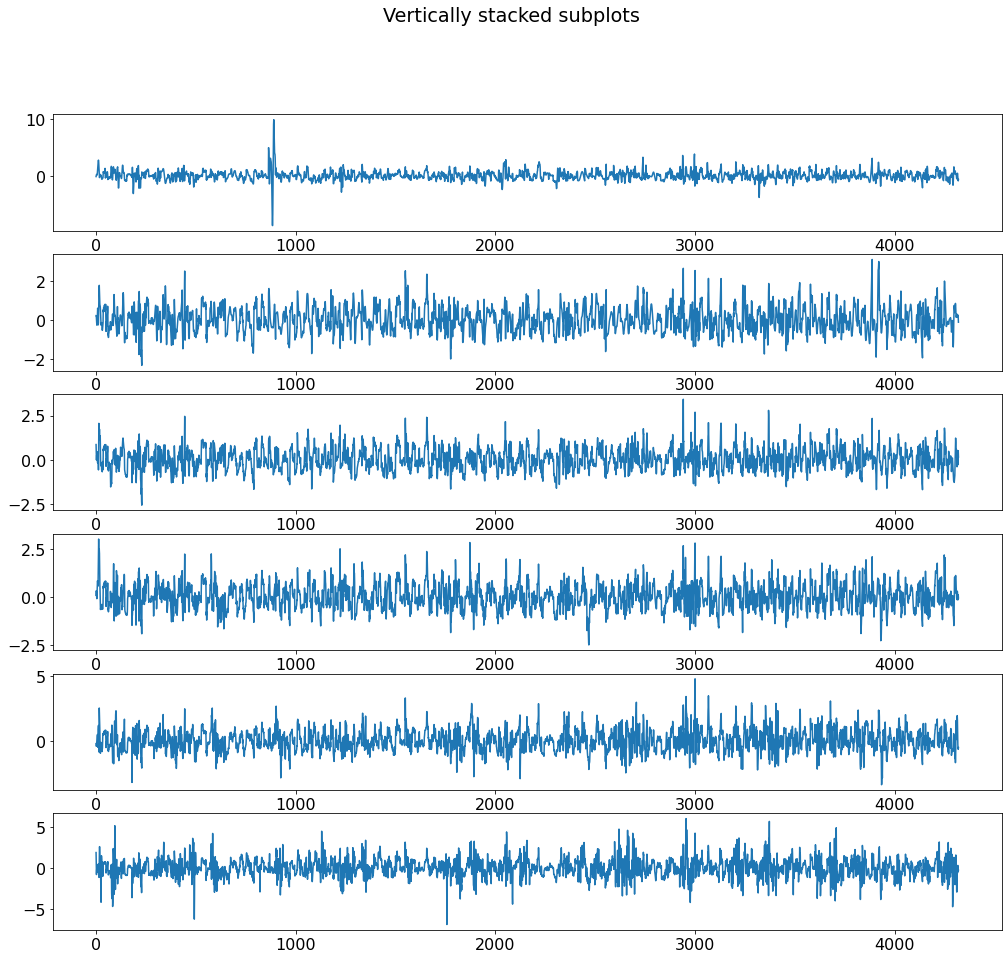

In [9]:
#print(x_train[1,:,:])
fig, ax = plt.subplots(6, figsize=(17, 15))
fig.suptitle('Vertically stacked subplots')

for i in range(6):
  arr = []
  for x in range(len(y_data)):
    if y_data[x] == 8:
      #print('max'+str(i)+': '+ str(np.max(x_train[x,:,i])))
      arr = np.append(arr,(X_data[x,:,i]))
  ax[i].plot(arr)
  # print('mean: ' + str(np.mean(arr)))
  # print('std: ' + str(np.std(arr)))

(2429, 36, 36, 1)


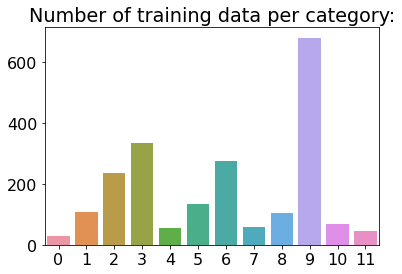

In [10]:
#Y_data = tfk.utils.to_categorical(y_data_tmp)
X_data = tfk.layers.Resizing(36, 36)(X_data)
#X_data = X_data[:, :, :, 0]
print(X_data.shape)

skf = StratifiedKFold(8)
#skf = skf.get_n_splits(X_data, Y_data)

for i, (train_index, test_index) in enumerate(skf.split(X_data, y_data)):
  classes = np.zeros(12)
  for x in y_data[train_index]:
    classes[x] +=1

  sns.barplot(x=np.arange(12), y=classes).set_title("Number of training data per category:")

In [12]:
X_train = np.reshape(X_data,(X_data.shape[0],X_data.shape[1],X_data.shape[2],1))
print(X_train.shape)

Y_data = tfk.utils.to_categorical(y_data)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_data, test_size=0.15, shuffle= True, stratify=Y_data)

(2429, 36, 36, 1)


In [13]:
Y_data = tfk.utils.to_categorical(y_data)

In [14]:
input_shape = X_data.shape[1:]
classes = y_data.shape[-1]
print(y_data.shape)
batch_size = 256
epochs = 400

(2429,)


# Models

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

## 2DCNN

In [15]:
from keras.layers import GaussianNoise
from keras.preprocessing.image import ImageDataGenerator



# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(height_shift_range=0.2, vertical_flip=True) 
aug_valid_data_gen = ImageDataGenerator()
aug_train_gen = aug_train_data_gen.flow(x=x_train,
                                        y=y_train,
                                        batch_size=8,
                                        shuffle=True,
                                        seed=seed)


aug_valid_gen = aug_valid_data_gen.flow(x=x_val,
                                        y=y_val,
                                        batch_size=8,
                                        shuffle=True,
                                        seed=seed)

In [16]:
def build_model(input_shape, index):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')



    x = tfkl.Conv2D(
        filters = 32,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1'+index)(input_layer)
    x = tfkl.MaxPooling2D(name='mp1'+index)(x)

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2'+index)(x)
    x = tfkl.MaxPooling2D(name='mp2'+index)(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv3'+index)(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv4'+index)(x)

    x = tfkl.Conv2D(
        filters = 512,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv5'+index)(x)
    
    # x = tfkl.Lambda(lambda x: x[:,:,:,0], input_shape=(*input_shape, 1))(x)

    # x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, dropout=.5))(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dropout(0.2, seed=seed, name='dropout2'+index)(x)

    x = tfkl.Dense(
        units = 64,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'classifier'+index)(x)

    x = tfkl.Dropout(0.2, seed=seed, name='dropout3'+index)(x)

    x = tfkl.Dense(
        units = 64,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'classifier2'+index)(x)

    output_layer = tfkl.Dense(
        units = 12, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer'+index)(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'model'+index)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model



In [17]:
lst_accu_stratified= []
list_history=[]
list_models=[]
i=0

for train_index, test_index in skf.split(X_data, y_data): 
    X_train_fold, X_test_fold = [X_data[i] for i in train_index], [X_data[i] for i in test_index]
    y_train_fold, y_test_fold = [y_data[i] for i in train_index], [y_data[i] for i in test_index]

    X_train_fold = np.array(X_train_fold)
    X_test_fold = np.array(X_test_fold)
    y_train_fold = np.array(y_train_fold)
    y_test_fold = np.array(y_test_fold)

    y_train_fold = tfk.utils.to_categorical(y_train_fold)
    y_test_fold = tfk.utils.to_categorical(y_test_fold)
    print(y_train_fold.shape)

    print("BUILDING MODEL " + str(i+1))

    model = build_model(input_shape, str(i))
    model.summary()

    history = model.fit(
      x = X_train_fold,
      y = y_train_fold,
      batch_size = batch_size,
      epochs = 400,
      shuffle = True,
      class_weight = class_weight,
      validation_data = (X_test_fold, y_test_fold),
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
          # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.5, min_lr=1e-5)
          ]
    ).history

    list_models.append(model)
    lst_accu_stratified.append(model.predict(X_test_fold))
    list_history.append(history)

    predicted_classes = np.argmax(model.predict(X_test_fold), axis=-1)
    print(predicted_classes)
    pp = np.argmax(y_test_fold, axis=-1)
    import sklearn.metrics
    print(sklearn.metrics.classification_report(pp, predicted_classes,output_dict = False))

    i+=1




(2125, 12)
BUILDING MODEL 1
Model: "model0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 36, 36, 1)]       0         
                                                                 
 conv10 (Conv2D)             (None, 36, 36, 32)        320       
                                                                 
 mp10 (MaxPooling2D)         (None, 18, 18, 32)        0         
                                                                 
 conv20 (Conv2D)             (None, 18, 18, 64)        18496     
                                                                 
 mp20 (MaxPooling2D)         (None, 9, 9, 64)          0         
                                                                 
 conv30 (Conv2D)             (None, 9, 9, 128)         73856     
                                                                 
 conv40 (Conv2D)             (No

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(2125, 12)
BUILDING MODEL 3
Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 36, 36, 1)]       0         
                                                                 
 conv12 (Conv2D)             (None, 36, 36, 32)        320       
                                                                 
 mp12 (MaxPooling2D)         (None, 18, 18, 32)        0         
                                                                 
 conv22 (Conv2D)             (None, 18, 18, 64)        18496     
                                                                 
 mp22 (MaxPooling2D)         (None, 9, 9, 64)          0         
                                                                 
 conv32 (Conv2D)             (None, 9, 9, 128)         73856     
                                                                 
 conv42 (Conv2D)             (No

In [19]:
from tensorflow.python.ops import template
from keras.models import Model
def build_full_model(input_shape):
  input_layer = tfkl.Input(shape=input_shape, name='full_input')
  res = tfk.layers.Resizing(36, 36)(input_layer)
  print(input_layer.shape)
  newList = []
  for i in range(len(list_models)):
    temp = Model(list_models[i].input, list_models[i].layers[-2].output)(res)
    temp.trainable = False
    newList.append(temp)
  
  x = tfk.layers.Concatenate()(newList)


  print("Ciaoo")
  #x = tfkl.Dropout(0.2)(x)
  #x = tfkl.Dense(256, activation='leaky_relu', name="dense_full1")(x)
  #x = tfkl.Dropout(0.2)(x)
  #x = tfkl.Dense(128, activation='leaky_relu', name="dense_full2")(x)

  output_layer = tfkl.Dense(
        units = 12, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer_full')(x)

    # Connect input and output through the Model class
  model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'model_full')


  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  # Return the model
  return model


In [22]:
print(input_shape)
model = build_full_model((36,36,1))
model.summary()

(36, 36, 1)
(None, 36, 36, 1)
Ciaoo
Model: "model_full"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 full_input (InputLayer)        [(None, 36, 36, 1)]  0           []                               
                                                                                                  
 resizing_2 (Resizing)          (None, 36, 36, 1)    0           ['full_input[0][0]']             
                                                                                                  
 model_8 (Functional)           (None, 64)           1604992     ['resizing_2[0][0]']             
                                                                                                  
 model_9 (Functional)           (None, 64)           1604992     ['resizing_2[0][0]']             
                                                     

In [23]:
for i, layer in enumerate(model.layers[:len(model.layers)-2]):
  layer.trainable= False
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 full_input False
1 resizing_2 False
2 model_8 False
3 model_9 False
4 model_10 False
5 model_11 False
6 model_12 False
7 model_13 False
8 model_14 False
9 model_15 False
10 concatenate_1 True
11 output_layer_full True


In [25]:
history = model.fit(
  x = X_data,
  y = Y_data,
  batch_size = batch_size,
  epochs = 10,
  shuffle = True
).history

Epoch 1/10
10/10 [==============================] - 1s 132ms/step - loss: 6.3939 - accuracy: 0.3508
Epoch 2/10
10/10 [==============================] - 1s 107ms/step - loss: 2.3297 - accuracy: 0.6406
Epoch 3/10
10/10 [==============================] - 1s 107ms/step - loss: 0.9742 - accuracy: 0.7950
Epoch 4/10
10/10 [==============================] - 1s 107ms/step - loss: 0.5152 - accuracy: 0.8637
Epoch 5/10
10/10 [==============================] - 1s 108ms/step - loss: 0.3108 - accuracy: 0.9057
Epoch 6/10
10/10 [==============================] - 1s 107ms/step - loss: 0.2464 - accuracy: 0.9214
Epoch 7/10
10/10 [==============================] - 1s 107ms/step - loss: 0.2139 - accuracy: 0.9304
Epoch 8/10
10/10 [==============================] - 1s 107ms/step - loss: 0.1972 - accuracy: 0.9374
Epoch 9/10
10/10 [==============================] - 1s 107ms/step - loss: 0.1678 - accuracy: 0.9490
Epoch 10/10
10/10 [==============================] - 1s 106ms/step - loss: 0.1595 - accuracy: 0.9494

In [ ]:
model.save('/gdrive/MyDrive/ANNDL/Homework2/models/KFolding2.0')